In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
def gaussian_pdf(x, mu=0, sigma=1):
    return 1/np.sqrt(2 * sigma ** 2 * np.pi) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def gaussian_cdf(x, mu=0, sigma=1):
    return norm(loc=mu, scale=sigma).cdf(x)

In [92]:
# estimate the probability of sampling a gaussian above some threshold
thresh = 5.
# correct answer is given by 1 - cdf(thresh)
print('true probability: {}'.format(1 - gaussian_cdf(thresh)))

true probability: 2.866515719235352e-07


In [93]:
# monte carlo 
def monte_carlo(thresh, N=10000, mu=0, sigma=1.):
    count = 0
    for i in range(N):
        s = np.random.randn() * sigma + mu
        if s > thresh:
            w = gaussian_pdf(s) / gaussian_pdf(s, mu=mu, sigma=sigma)
            count += w
    return count / float(N)

In [94]:
l_hat_mc = monte_carlo(thresh)
print('monte_carlo estimate: {}'.format(l_hat_mc)) # basically never samples it

monte_carlo estimate: 0.0


In [95]:
l_hat_mcis = monte_carlo(thresh, mu=thresh)
print('monte carlo importance sample estimate: {}'.format(l_hat_mcis)) # decent proposal dist, but variance too high

monte carlo importance sample estimate: 2.9482926441211803e-07


In [111]:
# importance sampling where the proposal distribution is selected via cross entropy method
def monte_carlo_cross_entropy(y, max_iters=50, N=1000, percentile=50):
    ### 1. initialize
    v = [0., 1.] # parameters same as f(.;u) => zero mean, unit variance normal
    
    for it in range(max_iters):
        
        ### 2. sample and recompute threshold
        # sample X
        X = np.random.randn(N) * v[1] + v[0]
        # compute top percentile 
        y_hat = min(y, np.percentile(X, percentile))
        # if y_hat >= y, then we've finished
        if y_hat >= y:
            break
        
        ### 3. update v
        top_X = X[X > y_hat]
        w = gaussian_pdf(top_X) / gaussian_pdf(top_X, mu=v[0], sigma=v[1])
        mu = np.sum(w * top_X) / np.sum(w)
        sigma = np.sqrt(np.sum(w * (top_X - v[0]) ** 2) / np.sum(w))
        v[0], v[1] = mu, sigma        
        
    ### 4. return the parameters, which can then be used for computing the estimate
    return v

In [113]:
mu, sigma = monte_carlo_cross_entropy(thresh, max_iters=100)
print('proposal mean {}'.format(mu))
print('proposal sigma {}'.format(sigma))
l_hat_mcec = monte_carlo(thresh, N=100, mu=mu, sigma=sigma)
print('monte carlo cross entropy method estimate: {}'.format(l_hat_mcis)) # essentially the same as IS with lower var

proposal mean 5.038680955948731
proposal sigma 0.26200066043473075
monte carlo cross entropy method estimate: 2.9482926441211803e-07


In [114]:
# compare them
thresh = 5.
num_steps = 10
num_samples = [int(v) for v in np.linspace(100, 100000, num_steps)]

# params
proposal_parameters = np.empty((3, 2))
# crude monte carlo uses unit gaussian
proposal_parameters[0,0] = 0
proposal_parameters[0,1] = 1.
# importance sampling uses unit variance gaussian centered at threshold
proposal_parameters[1,0] = thresh
proposal_parameters[1,1] = 1.
# use cross entropy method to find parameters
proposal_parameters[2,:] = monte_carlo_cross_entropy(thresh, max_iters=100, N=10000)

estimates = np.empty((num_steps, 3))
for i, N in enumerate(num_samples):
    for j, params in enumerate(proposal_parameters):
        estimates[i, j] = monte_carlo(thresh, N=N, mu=params[0], sigma=params[1])
    
true_prob = 1 - gaussian_cdf(thresh)
print('true probability: {}'.format(true_prob))
print('monte carlo: {}'.format(estimates[-1,0]))
print('monte carlo importance sampling: {}'.format(estimates[-1,1]))
print('monte carlo cross entropy method: {}'.format(estimates[-1,2]))

true probability: 2.866515719235352e-07
monte carlo: 0.0
monte carlo importance sampling: 2.874814475220717e-07
monte carlo cross entropy method: 2.867296385257778e-07


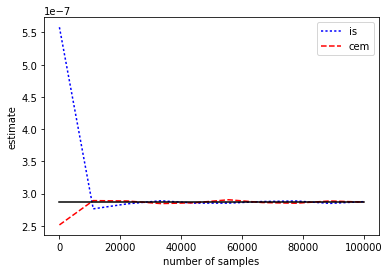

In [117]:
# plt.scatter(num_samples, estimates[:,0], c='green', label='cmc') # cmc never samples it basically
xmin, xmax = np.min(num_samples), np.max(num_samples)
ymin, ymax = np.min(estimates[:,1:]), np.max(estimates[:,1:])
plt.axis=([xmin,xmax,ymin,ymax])
plt.plot(num_samples, estimates[:,1], c='blue', label='is', ls=':')
plt.plot(num_samples, estimates[:,2], c='red', label='cem', ls='--')
plt.plot((xmin, xmax), (true_prob, true_prob), 'k-')
plt.xlabel('number of samples')
plt.ylabel('estimate')
plt.legend()
plt.show()

In [ ]:
"""
# Algo Overview:
- cross entropy method is a general optimization method that you can also use for simulating rare events
- for rare event simulation, you use cem to find the parameters of the proposal distribution to use in IS
- where that proposal distribution is typically limited to some family of parametric functions
- and where the best instantiation of that family of functions is the one that minimizes the kl divergence 
    between itself and the optimal proposal distribution g*
    - you could not limit it to a parametric family, but then it would be difficult to compute the updated 
        parameters potentially (or at least you might not do be able to do it analytically).

# Optimal proposal dist:
- the optimal proposal distribution g* is the one that minimizes the variance in estimating some value l
    - g* = 1{S(X) > y} * f(X;u) / l
        - where 1{S(X) > y} is an indicator function for some function of X, S(X) being larger than a threshold gamma
        - f(X;u) is the original distribution
        - l is the quantity of interest
    - the reason g* is the optimal proposal distribution is because if you had it then you would only need a single
        sample to determine l
        - intuitively, this is because g* only gives positive probability to samples that meet the criteria (1{S(X) > y})
            and does so proportionally to f(X;u). g* only requires a single sample as a result because the proportional
            weighting is such that l (the quantity of interest) is the normalizing constant.

# The optimization:
- one clever thing about it is how it goes about finding proposal distributions when the desired event is rare
    - it's answer to this problem is that it ignores the "rarity" of the event at first 
        - i.e., it states with a gamma that is easy to fulfil
    - and iteratively makes that gamma closer to the true gamma
    - what's good about this is that it works at all
    - what's bad about this is that if the optimization landscape is nonconvex then you'll get stuck in local optima
        - though it seems like this might not be that big a deal in practice b/c people typically adhere to 
            certain parametric families
        - also not that big a deal as a result of using KL divergence
            - this basically results in analytical solutions

# additional notes:
- it is essentially a genetic programming, hill climbing algorithm 
    - in the sense that it assumes that by iteratively increasing lambda and keeping samples that do well at this
        it will find an acceptable solution to the proposal distribution parameters
- note that the optimization of v must be convex and continuous to get the optimal solution
    - for example, I initially started with the example of finding the sampling distribution to use with a
        bernoulli, and that doesn't work b/c not continuous
- see written notes for more details

# description of the above notebook:
- the above notebook compares crude monte carlo, importance sampling with a heuristicly selected proposal distribution
    and monte carlo using a proposal distribution selected via the cross entropy method
- in each case, the monte carlo is trying to do the following
    - estimate the probability that a unit gaussian is sampled above some threshold
    - you can of course just compute the answer to this with the gaussian cdf
    - X = samples
    - S(X) = value of X
    - y = threshold
    - 1[S(X) > y] = condition for scoring
    - f(.;u) = original distribution (unit gaussian)
    - f(.;v) = distribution learned via cem
    - g* = optimal proposal distribution (not actually sure what this would be)
    - the equations for v above you get by formulating a sum over the samples, taking derivative wrt mu and sigma
        and then solving for the optimal values 
        - this works with gaussians
            mu = (sum_i w_i x_i) / (sum_i w_i)
            sigma^2 = (sum_i w_i (x_i - mu)^2) / (sum_i w_i)
         
# questions:
- why it is called the cross entropy method
    - is it the cross entropy between the parameters that fit the current samples and g*? 
        - kinda, it's called that because it finds the parameters v in f(.;v) that minimize the kl between f(.;v) 
            and g*, and does so optimally in certain cases.
- what exactly does the w term in the update accomplish?
    - weights the samples based on their similarity with the original sampling distribution, which is part of 
        finding the v of f(.;v) that minimizes kl with g*
        
# refs
- http://web.mit.edu/6.454/www/www_fall_2003/gew/CEsummary.pdf
- http://ieeexplore.ieee.org/document/7534875/
- http://arc.aiaa.org/doi/abs/10.2514/1.D0020?journalCode=jat
"""